In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
import warnings
import os

In [36]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

In [37]:
movies_processing = pd.read_csv('../프로젝트csv/movies.csv')

In [38]:
# 월_계절 컬럼 만들기
def movie_season(month):
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

In [39]:
movies_processing['개봉월'] = pd.to_numeric(movies_processing['개봉월'], errors='coerce')
movies_processing['계절'] = movies_processing['개봉월'].apply(movie_season)
movies_processing['계절']

0       4
1       4
2       4
3       4
4       4
       ..
6019    3
6020    2
6021    3
6022    3
6023    2
Name: 계절, Length: 6024, dtype: int64

In [40]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_processing['장르'].unique())}
# movies_genre
movies_processing['장르2'] = movies_processing['장르'].map(movies_genre)
print(movies_processing[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [41]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_processing['등급_le'] = le.fit_transform(movies_processing['등급'])
movies_processing['관람객수_le'] = le.fit_transform(movies_processing['관람객수'])
movies_processing['계절_le'] = le.fit_transform(movies_processing['계절'])

X = movies_processing[['장르2', '총스크린수', '관람객수_le', '등급_le']]
y = movies_processing['계절_le']

In [42]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4819, 4), (4819,), (1205, 4), (1205,))

In [43]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(4,)), # 입력데이터의 colunm 수
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(movies_processing['계절_le'].unique()), activation='softmax')  # 계절의 개수만큼 출력층 생성
])

In [46]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_sea-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                            verbose=1)               

hist = model.fit(X_train, y_train, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = [checkpoint, earlyStopping]
                )

Epoch 1/500
114/121 [===========================>..] - ETA: 0s - loss: 1.3655 - accuracy: 0.3111
Epoch 1: val_accuracy improved from -inf to 0.32469, saving model to ./model\movies_sea-001-val0.3247.h5
121/121 [==============================] - 1s 8ms/step - loss: 1.3642 - accuracy: 0.3136 - val_loss: 1.3687 - val_accuracy: 0.3247
Epoch 2/500
120/121 [============================>.] - ETA: 0s - loss: 1.3615 - accuracy: 0.3122
Epoch 2: val_accuracy did not improve from 0.32469
121/121 [==============================] - 1s 6ms/step - loss: 1.3616 - accuracy: 0.3126 - val_loss: 1.3678 - val_accuracy: 0.3060
Epoch 3/500
120/121 [============================>.] - ETA: 0s - loss: 1.3648 - accuracy: 0.3094
Epoch 3: val_accuracy did not improve from 0.32469
121/121 [==============================] - 1s 7ms/step - loss: 1.3649 - accuracy: 0.3089 - val_loss: 1.3692 - val_accuracy: 0.3247
Epoch 4/500
112/121 [==========================>...] - ETA: 0s - loss: 1.3589 - accuracy: 0.3262
Epoch 4: val

121/121 [==============================] - 1s 5ms/step - loss: 1.3223 - accuracy: 0.3696 - val_loss: 1.3553 - val_accuracy: 0.3122
Epoch 30/500
110/121 [==========================>...] - ETA: 0s - loss: 1.3226 - accuracy: 0.3625
Epoch 30: val_accuracy did not improve from 0.34855
121/121 [==============================] - 1s 5ms/step - loss: 1.3201 - accuracy: 0.3665 - val_loss: 1.3493 - val_accuracy: 0.3174
Epoch 31/500
120/121 [============================>.] - ETA: 0s - loss: 1.3143 - accuracy: 0.3750
Epoch 31: val_accuracy did not improve from 0.34855
121/121 [==============================] - 1s 5ms/step - loss: 1.3140 - accuracy: 0.3751 - val_loss: 1.3543 - val_accuracy: 0.3205
Epoch 32/500
116/121 [===========================>..] - ETA: 0s - loss: 1.3114 - accuracy: 0.3712
Epoch 32: val_accuracy did not improve from 0.34855
121/121 [==============================] - 1s 5ms/step - loss: 1.3112 - accuracy: 0.3728 - val_loss: 1.3478 - val_accuracy: 0.3434
Epoch 33/500
114/121 [====

Epoch 58/500
115/121 [===========================>..] - ETA: 0s - loss: 1.2693 - accuracy: 0.4008
Epoch 58: val_accuracy did not improve from 0.36618
121/121 [==============================] - 1s 5ms/step - loss: 1.2702 - accuracy: 0.4003 - val_loss: 1.3440 - val_accuracy: 0.3423
Epoch 59/500
115/121 [===========================>..] - ETA: 0s - loss: 1.2798 - accuracy: 0.4035
Epoch 59: val_accuracy did not improve from 0.36618
121/121 [==============================] - 1s 6ms/step - loss: 1.2802 - accuracy: 0.4029 - val_loss: 1.3369 - val_accuracy: 0.3600
Epoch 60/500
115/121 [===========================>..] - ETA: 0s - loss: 1.2776 - accuracy: 0.3872
Epoch 60: val_accuracy did not improve from 0.36618
121/121 [==============================] - 1s 5ms/step - loss: 1.2787 - accuracy: 0.3883 - val_loss: 1.3348 - val_accuracy: 0.3620
Epoch 61/500
117/121 [============================>.] - ETA: 0s - loss: 1.2743 - accuracy: 0.3865
Epoch 61: val_accuracy improved from 0.36618 to 0.37137, sa

Epoch 87/500
121/121 [==============================] - ETA: 0s - loss: 1.2435 - accuracy: 0.4122
Epoch 87: val_accuracy did not improve from 0.38071
121/121 [==============================] - 1s 5ms/step - loss: 1.2435 - accuracy: 0.4122 - val_loss: 1.3354 - val_accuracy: 0.3631
Epoch 88/500
119/121 [============================>.] - ETA: 0s - loss: 1.2426 - accuracy: 0.4144
Epoch 88: val_accuracy did not improve from 0.38071
121/121 [==============================] - 1s 6ms/step - loss: 1.2425 - accuracy: 0.4143 - val_loss: 1.3386 - val_accuracy: 0.3527
Epoch 89/500
116/121 [===========================>..] - ETA: 0s - loss: 1.2449 - accuracy: 0.4119
Epoch 89: val_accuracy did not improve from 0.38071
121/121 [==============================] - 1s 6ms/step - loss: 1.2440 - accuracy: 0.4132 - val_loss: 1.3336 - val_accuracy: 0.3558
Epoch 90/500
121/121 [==============================] - ETA: 0s - loss: 1.2380 - accuracy: 0.4265
Epoch 90: val_accuracy did not improve from 0.38071
121/121

Epoch 116/500
119/121 [============================>.] - ETA: 0s - loss: 1.2070 - accuracy: 0.4438
Epoch 116: val_accuracy did not improve from 0.40249
121/121 [==============================] - 1s 5ms/step - loss: 1.2077 - accuracy: 0.4425 - val_loss: 1.3329 - val_accuracy: 0.3817
Epoch 117/500
118/121 [============================>.] - ETA: 0s - loss: 1.2156 - accuracy: 0.4351
Epoch 117: val_accuracy did not improve from 0.40249
121/121 [==============================] - 1s 5ms/step - loss: 1.2151 - accuracy: 0.4355 - val_loss: 1.3285 - val_accuracy: 0.3890
Epoch 118/500
110/121 [==========================>...] - ETA: 0s - loss: 1.2084 - accuracy: 0.4406
Epoch 118: val_accuracy did not improve from 0.40249
121/121 [==============================] - 1s 5ms/step - loss: 1.2091 - accuracy: 0.4423 - val_loss: 1.3250 - val_accuracy: 0.4015
Epoch 119/500
118/121 [============================>.] - ETA: 0s - loss: 1.2056 - accuracy: 0.4484
Epoch 119: val_accuracy did not improve from 0.40249

Epoch 145/500
119/121 [============================>.] - ETA: 0s - loss: 1.1719 - accuracy: 0.4630
Epoch 145: val_accuracy did not improve from 0.40975
121/121 [==============================] - 1s 5ms/step - loss: 1.1742 - accuracy: 0.4610 - val_loss: 1.3411 - val_accuracy: 0.3942
Epoch 146/500
119/121 [============================>.] - ETA: 0s - loss: 1.1882 - accuracy: 0.4512
Epoch 146: val_accuracy did not improve from 0.40975
121/121 [==============================] - 1s 5ms/step - loss: 1.1882 - accuracy: 0.4524 - val_loss: 1.3425 - val_accuracy: 0.3983
Epoch 147/500
113/121 [===========================>..] - ETA: 0s - loss: 1.1751 - accuracy: 0.4574
Epoch 147: val_accuracy did not improve from 0.40975
121/121 [==============================] - 1s 5ms/step - loss: 1.1771 - accuracy: 0.4581 - val_loss: 1.3540 - val_accuracy: 0.3724
Epoch 148/500
109/121 [==========================>...] - ETA: 0s - loss: 1.1804 - accuracy: 0.4558
Epoch 148: val_accuracy did not improve from 0.40975

Epoch 174/500
115/121 [===========================>..] - ETA: 0s - loss: 1.1666 - accuracy: 0.4647
Epoch 174: val_accuracy did not improve from 0.41390
121/121 [==============================] - 1s 5ms/step - loss: 1.1665 - accuracy: 0.4654 - val_loss: 1.3446 - val_accuracy: 0.3890
Epoch 175/500
115/121 [===========================>..] - ETA: 0s - loss: 1.1700 - accuracy: 0.4652
Epoch 175: val_accuracy did not improve from 0.41390
121/121 [==============================] - 1s 5ms/step - loss: 1.1697 - accuracy: 0.4654 - val_loss: 1.3398 - val_accuracy: 0.3869
Epoch 176/500
117/121 [============================>.] - ETA: 0s - loss: 1.1609 - accuracy: 0.4663
Epoch 176: val_accuracy did not improve from 0.41390
121/121 [==============================] - 1s 6ms/step - loss: 1.1593 - accuracy: 0.4667 - val_loss: 1.3308 - val_accuracy: 0.3932
Epoch 177/500
117/121 [============================>.] - ETA: 0s - loss: 1.1641 - accuracy: 0.4557
Epoch 177: val_accuracy did not improve from 0.41390

In [47]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print('accuracy : {:.2f}'.format(accuracy*100), '%')

38/38 [==============================] - 0s 3ms/step - loss: 1.3222 - accuracy: 0.4000
accuracy : 40.00 %


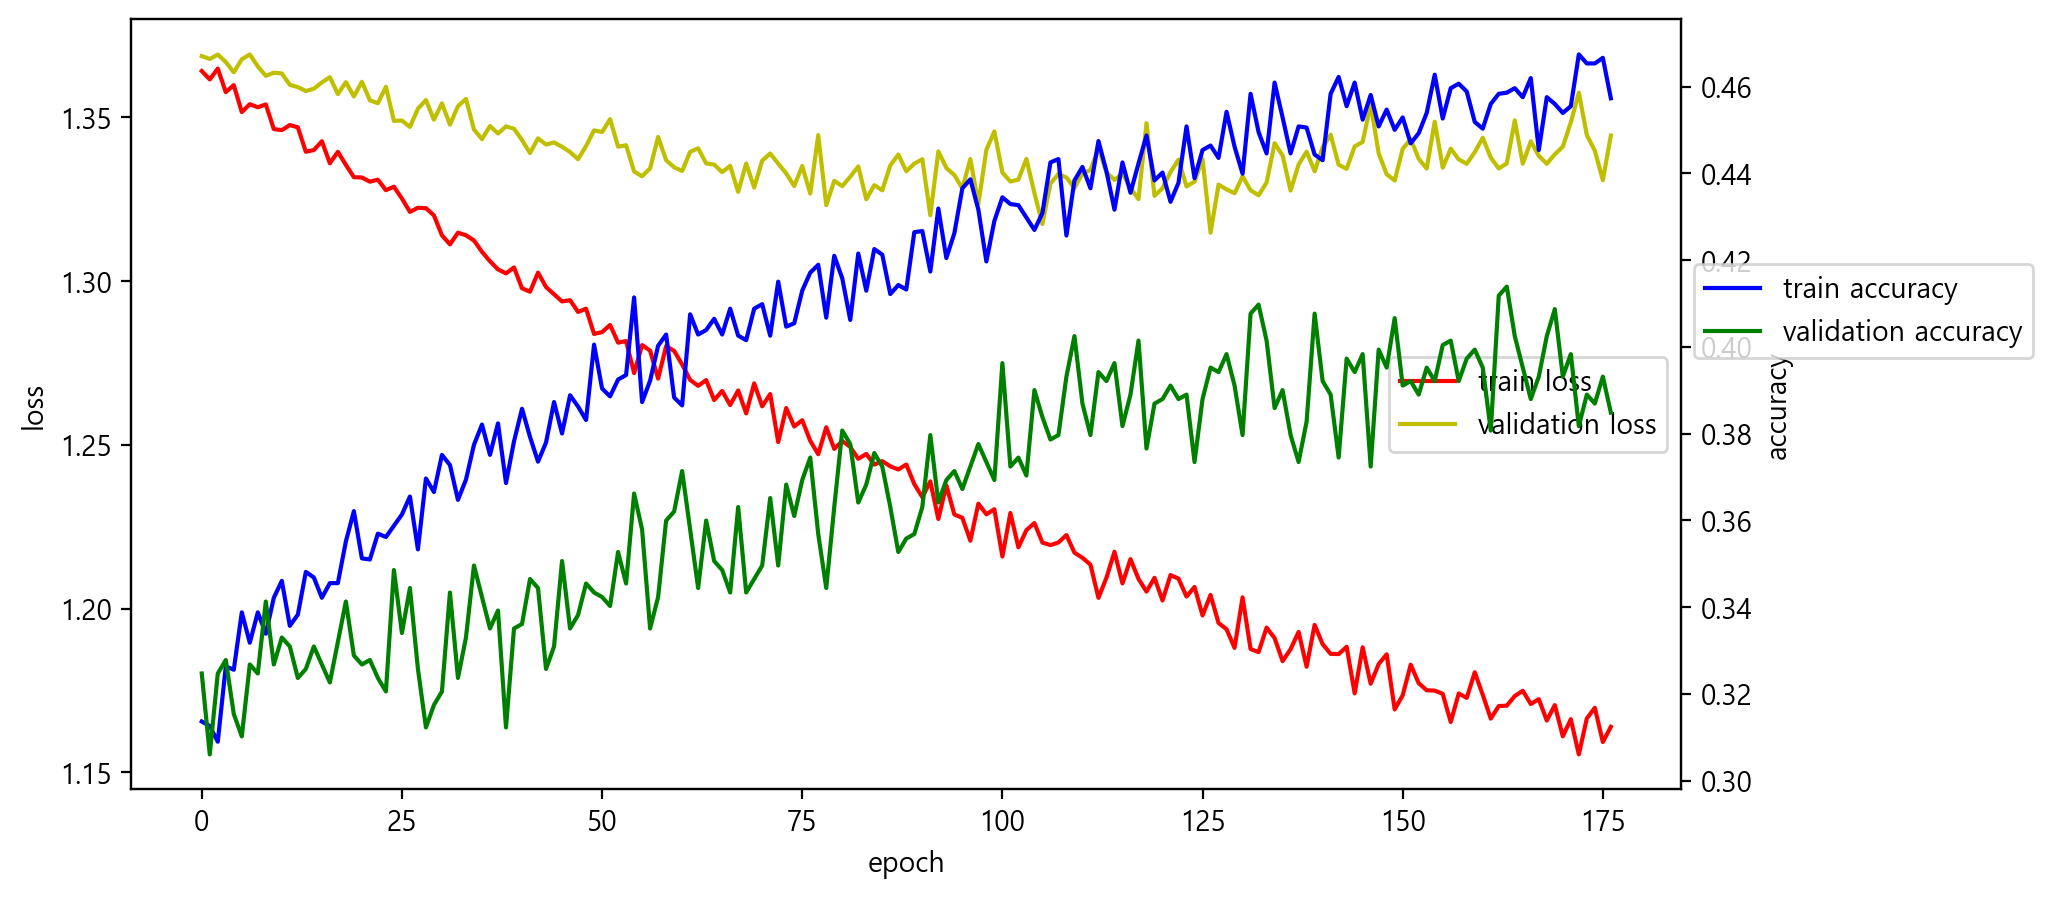

In [48]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [49]:
movies_processing.to_csv('../프로젝트csv/movies.csv', index=False, encoding='utf-8')